In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
from scipy.io import loadmat
from pathlib import Path
import matplotlib.patches as patches
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams
import numpy as np
import pandas as pd
# the following import is required for matplotlib < 3.2:
from mpl_toolkits.mplot3d import Axes3D  # noqa
from scipy import stats
import mne
import eeg_analysis.funcs4eeg as fe
import re
import imp
import ast
import behavior.func4behav as fb
imp.reload(fe)
imp.reload(fb)

C:\Users\Tianyi Zheng\AppData\Local\Temp\ipykernel_1512\3857904618.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


<module 'behavior.func4behav' from 'c:\\Users\\Tianyi Zheng\\OneDrive - neuron.t.u-tokyo.ac.jp\\Documents\\zheng\\mywork\\attention_tES\\tes-attention\\processing\\behavior\\func4behav.py'>

In [2]:
real_to_pick = [1, 3, 5, 9, 18]	
sham_to_pick = [6, 10, 11, 15, 16]

band_greek = ['α', 'β', 'γ']

diff_color = '#b8afe6'
font_size = 24
x_size = 9
y_size = 8.5
diff_x = 2.5
diff_y = -10

## Endo

In [3]:
case='3 | 4'
watch='1 fixation'
tmin = 0
tmax = 4.55

real_to_pick = [1, 3, 5, 9, 18]	
sham_to_pick = [6, 10, 11, 15, 16]
bands = [[8, 12], [12.5, 30], [30, 80]]
band_names = ['alpha', 'beta', 'gamma']

band_power = pd.DataFrame(columns=['band name', 'f low', 'f high', 'sham before', 
                                      'sham after', 'sham increase %', 'real before', 'real after', 'real increase %'])
band_power['band name'] = band_names
band_power['f low'] = [band[0] for band in bands]
band_power['f high'] = [band[1] for band in bands]

behavior_compare = fb.create_compare()
for subject_id in range (1,19):
    behavior_before, behavior_after = fb.load_behavior(subject_id)

    # endo
    behavior_before = behavior_before[behavior_before['type'] == 1]
    behavior_after = behavior_after[behavior_after['type'] == 1]

    behavior_compare = fb.make_compare(subject_id, behavior_before, behavior_after, behavior_compare) #, verbose=True)

for band_name in band_names:
    fmin = band_power[band_power['band name'] == band_name]['f low'].values[0]
    fmax = band_power[band_power['band name'] == band_name]['f high'].values[0]

    real_before = list()
    real_after = list()
    real_increase = list()
    for subject_id in real_to_pick:
        power_before, power_after = fe.pipeline_band_power(subject_id=subject_id, case=case, watch=watch, fmin=fmin, fmax=fmax, tmin=tmin, tmax=tmax)
        real_before.append(power_before)
        real_after.append(power_after)
        real_increase.append((power_after - power_before)/power_before*100)
    band_power.loc[band_power['band name'] == band_name, 'real before'] = str(real_before)
    band_power.loc[band_power['band name'] == band_name, 'real after'] = str(real_after)
    band_power.loc[band_power['band name'] == band_name, 'real increase %'] = str(real_increase)


    sham_before = list()
    sham_after = list()
    sham_increase = list()
    for subject_id in sham_to_pick:
        power_before, power_after = fe.pipeline_band_power(subject_id=subject_id, case=case, watch=watch, fmin=fmin, fmax=fmax, tmin=tmin, tmax=tmax)
        sham_before.append(power_before)
        sham_after.append(power_after)
        sham_increase.append((power_after - power_before)/power_before*100)
    band_power.loc[band_power['band name'] == band_name, 'sham before'] = str(sham_before)
    band_power.loc[band_power['band name'] == band_name, 'sham after'] = str(sham_after)
    band_power.loc[band_power['band name'] == band_name, 'sham increase %'] = str(sham_increase)
    

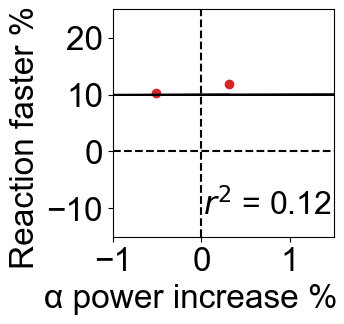

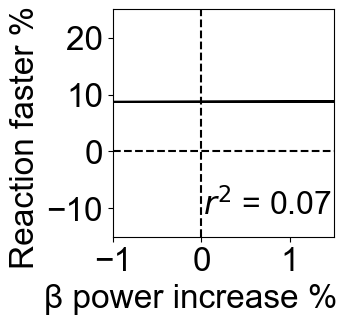

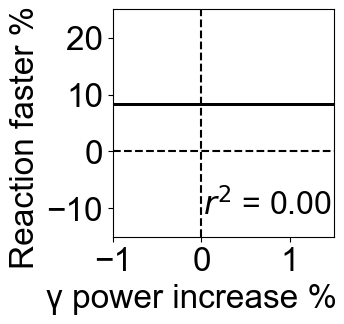

In [4]:
rc('font', family='Arial')
for i, compare_object in enumerate(band_names):
    watch = 'Endo'
    save_path = os.path.join('..', '..', '..','..','..', 'confNjral', 'EMBC2023', 'poster', 'figs', 'Corr_'+compare_object+'_'+watch+'.svg')

    x_real = np.array(band_power.loc[band_power['band name'] == compare_object, 'real increase %'].apply(ast.literal_eval).values[0])
    rows = behavior_compare[behavior_compare['subject id'].isin(real_to_pick)]
    y_real = rows['RT mean shorten %'].values
    
    x_sham = np.array(band_power.loc[band_power['band name'] == compare_object, 'sham increase %'].apply(ast.literal_eval).values[0])
    rows = behavior_compare[behavior_compare['subject id'].isin(sham_to_pick)]
    y_sham = rows['RT mean shorten %'].values

    # Remove the max value
    max_index = np.argmax(x_real)
    x_real = np.delete(x_real, max_index)
    y_real = np.delete(y_real, max_index)
    max_index = np.argmax(x_sham)
    x_sham = np.delete(x_sham, max_index)
    y_sham = np.delete(y_sham, max_index)
    
    # combine all data
    x_all = np.concatenate([x_real, x_sham])
    y_all = np.concatenate([y_real, y_sham])
    
    # perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_all.tolist(), y_all.tolist())
    r_squared = r_value**2  # Calculate R-squared value

    # plot data and regression line
    fig, ax = plt.subplots(figsize=(x_size/2.54, y_size/2.54)) # Sizes are in inches
    plt.scatter(x_real, y_real, color='#d62728', label='Real')
    plt.scatter(x_sham, y_sham, color='#1f77b4', label='Sham')
    plt.plot(x_all, intercept + slope*x_all, 'k')

    # Add a vertical dashed line at time=0s
    plt.axvline(x=0, color='k', linestyle='--')
    plt.axhline(y=0, color='k', linestyle='--')

    plt.xlabel(band_greek[i]+" power increase %       ", fontsize=font_size)
    plt.ylabel('Reaction faster %   ',fontsize=font_size)

    plt.xticks([-100, 0, 100], fontsize=font_size)
    plt.yticks([-10, 0, 10, 20], fontsize=font_size)
    plt.xlim([-100, 150])
    plt.ylim([-15, 25])
    
    # Annotate R-squared value on the plot
    plt.annotate('$r^2$ = {:.2f}'.format(r_squared), xy=(0.405, 0.1), xycoords='axes fraction', fontsize=23)

    plt.tight_layout()  # Adjust layout to fit labels
    plt.savefig(save_path, format='svg')
    plt.show()


## 

## Exo

In [5]:
case='5 | 6'
watch='1 fixation'
tmin = 0
tmax = 2.5

real_to_pick = [1, 3, 5, 9, 18]	
sham_to_pick = [6, 10, 11, 15, 16]
bands = [[8, 12], [12.5, 30], [30, 80]]
band_names = ['alpha', 'beta', 'gamma']

band_power = pd.DataFrame(columns=['band name', 'f low', 'f high', 'sham before', 
                                      'sham after', 'sham increase %', 'real before', 'real after', 'real increase %'])
band_power['band name'] = band_names
band_power['f low'] = [band[0] for band in bands]
band_power['f high'] = [band[1] for band in bands]

behavior_compare = fb.create_compare()
for subject_id in range (1,19):
    behavior_before, behavior_after = fb.load_behavior(subject_id)

    # exo
    behavior_before = behavior_before[behavior_before['type'] == 2]
    behavior_after = behavior_after[behavior_after['type'] == 2]

    behavior_compare = fb.make_compare(subject_id, behavior_before, behavior_after, behavior_compare) #, verbose=True)

for band_name in band_names:
    fmin = band_power[band_power['band name'] == band_name]['f low'].values[0]
    fmax = band_power[band_power['band name'] == band_name]['f high'].values[0]

    real_before = list()
    real_after = list()
    real_increase = list()
    for subject_id in real_to_pick:
        power_before, power_after = fe.pipeline_band_power(subject_id=subject_id, case=case, watch=watch, fmin=fmin, fmax=fmax, tmin=tmin, tmax=tmax)
        real_before.append(power_before)
        real_after.append(power_after)
        real_increase.append((power_after - power_before)/power_before*100)
    band_power.loc[band_power['band name'] == band_name, 'real before'] = str(real_before)
    band_power.loc[band_power['band name'] == band_name, 'real after'] = str(real_after)
    band_power.loc[band_power['band name'] == band_name, 'real increase %'] = str(real_increase)


    sham_before = list()
    sham_after = list()
    sham_increase = list()
    for subject_id in sham_to_pick:
        power_before, power_after = fe.pipeline_band_power(subject_id=subject_id, case=case, watch=watch, fmin=fmin, fmax=fmax, tmin=tmin, tmax=tmax)
        sham_before.append(power_before)
        sham_after.append(power_after)
        sham_increase.append((power_after - power_before)/power_before*100)
    band_power.loc[band_power['band name'] == band_name, 'sham before'] = str(sham_before)
    band_power.loc[band_power['band name'] == band_name, 'sham after'] = str(sham_after)
    band_power.loc[band_power['band name'] == band_name, 'sham increase %'] = str(sham_increase)
    

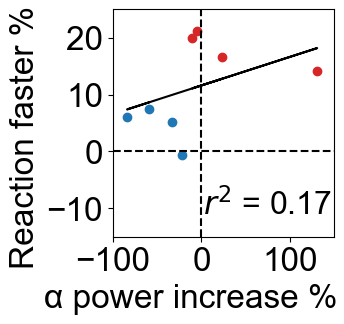

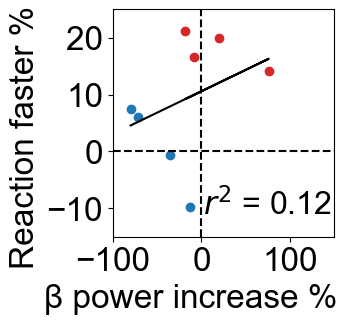

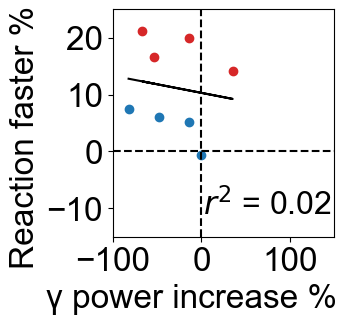

In [7]:
rc('font', family='Arial')
for i, compare_object in enumerate(band_names):
    watch = 'Exo'
    save_path = os.path.join('..', '..', '..','..','..', 'confNjral', 'EMBC2023', 'poster', 'figs', 'Corr_'+compare_object+'_'+watch+'.svg')

    x_real = np.array(band_power.loc[band_power['band name'] == compare_object, 'real increase %'].apply(ast.literal_eval).values[0])
    rows = behavior_compare[behavior_compare['subject id'].isin(real_to_pick)]
    y_real = rows['RT mean shorten %'].values
    
    x_sham = np.array(band_power.loc[band_power['band name'] == compare_object, 'sham increase %'].apply(ast.literal_eval).values[0])
    rows = behavior_compare[behavior_compare['subject id'].isin(sham_to_pick)]
    y_sham = rows['RT mean shorten %'].values

    # Remove the max value
    max_index = np.argmax(x_real)
    x_real = np.delete(x_real, max_index)
    y_real = np.delete(y_real, max_index)
    max_index = np.argmax(x_sham)
    x_sham = np.delete(x_sham, max_index)
    y_sham = np.delete(y_sham, max_index)
    
    # combine all data
    x_all = np.concatenate([x_real, x_sham])
    y_all = np.concatenate([y_real, y_sham])
    
    # perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_all.tolist(), y_all.tolist())
    r_squared = r_value**2  # Calculate R-squared value

    # plot data and regression line
    fig, ax = plt.subplots(figsize=(x_size/2.54, y_size/2.54)) # Sizes are in inches
    plt.scatter(x_real, y_real, color='#d62728', label='Real')
    plt.scatter(x_sham, y_sham, color='#1f77b4', label='Sham')
    plt.plot(x_all, intercept + slope*x_all, 'k')

    # Add a vertical dashed line at time=0s
    plt.axvline(x=0, color='k', linestyle='--')
    plt.axhline(y=0, color='k', linestyle='--')

    plt.xlabel(band_greek[i]+" power increase %       ", fontsize=font_size)
    plt.ylabel('Reaction faster %   ',fontsize=font_size)

    plt.xticks([-100, 0, 100], fontsize=font_size)
    plt.yticks([-10, 0, 10, 20], fontsize=font_size)
    plt.xlim([-100, 150])
    plt.ylim([-15, 25])
    
    # Annotate R-squared value on the plot
    plt.annotate('$r^2$ = {:.2f}'.format(r_squared), xy=(0.405, 0.1), xycoords='axes fraction', fontsize=23)

    plt.tight_layout()  # Adjust layout to fit labels
    plt.savefig(save_path, format='svg')
    plt.show()
